# Message Concealment Scheme

## Libraries and initial setup

In [2]:
!pip3 install gmpy2
!pip3 install tensorflow

%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [27]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-gpu
# !pip install keras==2.3.1



In [3]:
from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, RMSprop
# from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model

Using TensorFlow backend.


In [29]:
# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

In [30]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

## Model Building

### Alice

In [31]:
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('relu')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('sigmoid')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('sigmoid')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('sigmoid')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')
# alice.summary()


### Bob

In [32]:
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('relu')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1a = Activation('sigmoid')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('sigmoid')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('sigmoid')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

boutput = Flatten()(bconv4a)

bob = Model([binput0, binput1], boutput, name='bob')

# bob.summary()

### Eve

In [33]:
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('relu')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('relu')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('sigmoid')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('sigmoid')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('sigmoid')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eoutput = Flatten()(econv4a)# Eve's attempt at code guessing

eve = Model(einput, eoutput, name='eve')

# eve.summary()

In [34]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

## Loss Functions and Optimizers

In [35]:
m_train = 2**(m_bits) #+ k_bits)

In [36]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/Users/prasannshimpi/opt/anaconda3/envs/tensor_env/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/Users/prasannshimpi/opt/anaconda3/envs/tensor_env/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


## Training and Dump

In [37]:
abelosses = []
boblosses = []
evelosses = []

In [38]:
n_epochs = 150 
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = [] 
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 150 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 7.995 | eve: 8.000 | bob: 7.995
Epoch   1:  99% | abe: 8.001 | eve: 7.998 | bob: 8.000
Epoch   2:  99% | abe: 7.992 | eve: 7.996 | bob: 7.992
Epoch   3:  99% | abe: 7.979 | eve: 7.880 | bob: 7.977
Epoch   4:  99% | abe: 7.603 | eve: 7.021 | bob: 7.578
Epoch   5:  99% | abe: 6.416 | eve: 5.397 | bob: 6.292
Epoch   6:  99% | abe: 4.972 | eve: 4.185 | bob: 4.728
Epoch   7:  99% | abe: 3.725 | eve: 3.360 | bob: 3.371
Epoch   8:  99% | abe: 2.846 | eve: 2.458 | bob: 2.350
Epoch   9:  99% | abe: 2.180 | eve: 1.507 | bob: 1.507
Epoch  10:  99% | abe: 1.685 | eve: 0.976 | bob: 0.902
Epoch  11:  99% | abe: 1.304 | eve: 0.755 | bob: 0.473
Epoch  12:  99% | abe: 1.082 | eve: 0.656 | bob: 0.231
Epoch  13:  99% | abe: 0.986 | eve: 0.617 | bob: 0.129
Epoch  14:  99% | abe: 0.944 | eve: 0.635 | bob: 0.091
Epoch  15:  99% | abe: 0.910 | eve: 0.726 | bob: 0.078
Epoch  16:  99% | abe: 0.882 | eve: 0.824 | bob: 0.071
Epoch  17:  

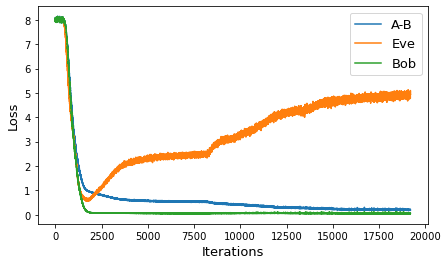

In [45]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

### Saving

In [40]:
# import joblib

# joblib.dump(alice, '/content/drive/MyDrive/FYP-Neural Cryptography/alice.sav')
# joblib.dump(bob, '/content/drive/MyDrive/FYP-Neural Cryptography/bob.sav')
# joblib.dump(eve, '/content/drive/MyDrive/FYP-Neural Cryptography/eve.sav')

In [47]:
# alice.save('alice.h5',overwrite=True)
# bob.save('bob.h5',overwrite=True)
# eve.save('eve.h5',overwrite=True)

## Evaluate

In [46]:
n_examples = 10000
m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  99.99 %
Eve % correct:  0.14 %


In [6]:
!python -V

Python 3.6.13 :: Anaconda, Inc.


In [5]:
# Input format

# !pip3 install joblib

# load_model works with Python 3.6.13 :: Anaconda, Inc.

import joblib

alice1 = load_model('alice.h5')
bob1 = load_model('bob.h5')
eve1 = load_model('eve.h5')

message = np.array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
                    [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]])
key = np.array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
                [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])

cipher = alice1.predict([message, key])

decipher = (bob1.predict([cipher, key]) > 0.5).astype(int)

adversary = (eve1.predict(cipher) > 0.5).astype(int)

decipher[1]

# Input must be numpy array

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [ ]:
# !pip install h5py==2.10.0

In [ ]:
(bob.predict([m_enc, k_batch]) > 0.5).astype(int)

array([[0, 0, 0, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       ...,
       [0, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 1, 1]])

In [ ]:
(eve.predict(m_enc) > 0.5 ).astype(int)

array([[0, 0, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 1]])

Make Epochs 50 for better visualization